In [ ]:
# 导入所需库
import pandas as pd
import numpy as np
import random

# 文件路径
inventory_forecast_path = '所有品类库存量预测结果.csv'
sales_forecast_path = '最终日销量预测结果.csv'
warehouse_info_path = '附件3.csv'
category_correlation_path = '附件4.csv'

# 读取数据
inventory_forecast_df = pd.read_csv(inventory_forecast_path, encoding='gbk')
sales_forecast_df = pd.read_csv(sales_forecast_path)
warehouse_info_df = pd.read_csv(warehouse_info_path, encoding='gbk')
category_correlation_df = pd.read_csv(category_correlation_path, encoding='gbk')

# 数据预处理
inventory_forecast_df.rename(columns={'Unnamed: 0': '品类'}, inplace=True)

# 提取仓库容量、产能、租金成本
warehouse_capacity = warehouse_info_df.set_index('仓库')['仓容上限'].to_dict()
warehouse_output_capacity = warehouse_info_df.set_index('仓库')['产能上限'].to_dict()
warehouse_rent = warehouse_info_df.set_index('仓库')['仓租日成本'].to_dict()

# 提取库存量和销量预测
inventory_forecast = inventory_forecast_df.set_index('品类').to_dict('index')
sales_forecast = sales_forecast_df.set_index('品类').to_dict('index')

# 提取品类关联度
def extract_correlation(df):
    correlation_dict = {}
    for _, row in df.iterrows():
        correlation_dict[(row['品类1'], row['品类2'])] = row['关联度']
    return correlation_dict

category_correlation = extract_correlation(category_correlation_df)

# 定义模拟退火算法参数
initial_temperature = 10000
temperature_decay = 0.995
min_temperature = 1
iterations_per_temp = 100

# 初始化分配方案
categories = inventory_forecast_df['品类'].tolist()
warehouses = list(warehouse_capacity.keys())
current_solution = {category: random.choice(warehouses) for category in categories}

# 计算目标函数值
def calculate_cost(solution):
    cost_term = sum(warehouse_rent[solution[i]] for i in categories)
    utilization_term = 0
    correlation_term = 0
    
    # 计算仓容利用率（包括7月、8月、9月）
    for j in warehouses:
        total_inventory_7 = sum(inventory_forecast[i]['7月库存量'] for i in categories if solution[i] == j)
        total_inventory_8 = sum(inventory_forecast[i]['8月库存量'] for i in categories if solution[i] == j)
        total_inventory_9 = sum(inventory_forecast[i]['9月库存量'] for i in categories if solution[i] == j)
        total_output = sum(sales_forecast[i]['7月1日'] for i in categories if solution[i] == j) 
        
        # 添加惩罚项，如果超过仓容或产能上限
        if total_inventory_7 > warehouse_capacity[j] or total_inventory_8 > warehouse_capacity[j] or total_inventory_9 > warehouse_capacity[j]:
            utilization_term += 1e10  # 更大的惩罚项
        if total_output > warehouse_output_capacity[j]:
            utilization_term += 1e10  # 更大的惩罚项

        utilization_term += (((total_inventory_7 + total_inventory_8 + total_inventory_9) / 3) / warehouse_capacity[j]) 


    # 计算品类关联度
    for (i, k), correlation in category_correlation.items():
        if solution[i] == solution.get(k):
            correlation_term -= correlation

    return cost_term + utilization_term + correlation_term

# 初始化最优解
current_cost = calculate_cost(current_solution)
best_solution = current_solution.copy()
best_cost = current_cost

# 模拟退火过程
temp = initial_temperature
while temp > min_temperature:
    for _ in range(iterations_per_temp):
        # 生成一个新的邻域解
        new_solution = current_solution.copy()
        random_category = random.choice(categories)
        new_solution[random_category] = random.choice(warehouses)
        
        # 计算新解的成本
        new_cost = calculate_cost(new_solution)
        
        # 判断是否接受新解
        if new_cost < current_cost or random.uniform(0, 1) < np.exp((current_cost - new_cost) / temp):
            current_solution = new_solution
            current_cost = new_cost
            
            # 更新最优解
            if current_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = current_cost
    
    # 降低温度
    temp *= temperature_decay

# 保存分仓方案为 CSV 文件
allocation_df = pd.DataFrame(list(best_solution.items()), columns=['品类', '仓库'])
allocation_df.to_csv('一品一仓分仓方案_模拟退火_改进版.csv', index=False)
print("分仓方案已保存到：一品一仓分仓方案_模拟退火_改进版.csv")


分仓方案已保存到：一品一仓分仓方案_模拟退火_改进版.csv


In [42]:
# 导入所需库
import pandas as pd
import numpy as np
import random

# 文件路径
inventory_forecast_path = '所有品类库存量预测结果.csv'
sales_forecast_path = '最终日销量预测结果.csv'
warehouse_info_path = '附件3.csv'
category_correlation_path = '附件4.csv'

# 读取数据
inventory_forecast_df = pd.read_csv(inventory_forecast_path)
sales_forecast_df = pd.read_csv(sales_forecast_path)
warehouse_info_df = pd.read_csv(warehouse_info_path, encoding='gbk')
category_correlation_df = pd.read_csv(category_correlation_path, encoding='gbk')

# 数据预处理
inventory_forecast_df.rename(columns={'Unnamed: 0': '品类'}, inplace=True)

# 提取仓库容量、产能、租金成本
warehouse_capacity = warehouse_info_df.set_index('仓库')['仓容上限'].to_dict()
warehouse_output_capacity = warehouse_info_df.set_index('仓库')['产能上限'].to_dict()
warehouse_rent = warehouse_info_df.set_index('仓库')['仓租日成本'].to_dict()

# 提取库存量和销量预测
inventory_forecast = inventory_forecast_df.set_index('品类').to_dict('index')
sales_forecast = sales_forecast_df.set_index('品类').to_dict('index')

# 提取品类关联度
def extract_correlation(df):
    correlation_dict = {}
    for _, row in df.iterrows():
        correlation_dict[(row['品类1'], row['品类2'])] = row['关联度']
    return correlation_dict

category_correlation = extract_correlation(category_correlation_df)

# 粒子群优化算法参数
num_particles = 50
num_iterations = 100
w = 0.5  # 惯性权重
c1 = 1.5  # 认知权重
c2 = 1.5  # 社会权重

# 初始化分配方案
categories = inventory_forecast_df['品类'].tolist()
warehouses = list(warehouse_capacity.keys())
num_categories = len(categories)
num_warehouses = len(warehouses)

# 将仓库编号映射到整数，以便于操作
warehouse_to_index = {warehouse: idx for idx, warehouse in enumerate(warehouses)}
index_to_warehouse = {idx: warehouse for warehouse, idx in warehouse_to_index.items()}

# 初始化粒子的位置和速度
particles = [np.random.choice(range(num_warehouses), num_categories).tolist() for _ in range(num_particles)]
velocities = [np.zeros(num_categories).tolist() for _ in range(num_particles)]

# 计算目标函数值
def calculate_cost(solution):
    mapped_solution = [index_to_warehouse[idx] for idx in solution]
    cost_term = sum(warehouse_rent[mapped_solution[i]] for i in range(num_categories))
    utilization_term = 0
    correlation_term = 0
    
    # 计算仓容和产能利用率，考虑7月、8月和9月的库存量以及日均出库量
    for j in warehouses:
        total_inventory_7 = sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
        total_inventory_8 = sum(inventory_forecast[categories[i]]['8月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
        total_inventory_9 = sum(inventory_forecast[categories[i]]['9月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
        
        # 计算7、8、9月的日均出库量
        total_output_7 = sum(sales_forecast[categories[i]].get('7月总销量', 0) for i in range(num_categories) if mapped_solution[i] == j)
        total_output_8 = sum(sales_forecast[categories[i]].get('8月总销量', 0) for i in range(num_categories) if mapped_solution[i] == j)
        total_output_9 = sum(sales_forecast[categories[i]].get('9月总销量', 0) for i in range(num_categories) if mapped_solution[i] == j)
        num_days_7 = 31  # 7月天数
        num_days_8 = 31  # 8月天数
        num_days_9 = 30  # 9月天数
        avg_output = (total_output_7 / num_days_7 + total_output_8 / num_days_8 + total_output_9 / num_days_9) / 3
        
        # 如果库存或产能超限，加入惩罚项
        if total_inventory_7 > warehouse_capacity[j] or total_inventory_8 > warehouse_capacity[j] or total_inventory_9 > warehouse_capacity[j]:
            utilization_term += 1e7  # 增大惩罚项
        if avg_output > warehouse_output_capacity[j]:
            utilization_term += 1e7  # 增大惩罚项
        
        # 计算仓容和产能利用率，鼓励高利用率
        utilization_term -= (total_inventory_7 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
        utilization_term -= (total_inventory_8 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
        utilization_term -= (total_inventory_9 / warehouse_capacity[j] if warehouse_capacity[j] > 0 else 0)
        utilization_term -= (avg_output / warehouse_output_capacity[j] if warehouse_output_capacity[j] > 0 else 0)
    
    # 计算品类关联度
    for (i, k), correlation in category_correlation.items():
        if mapped_solution[categories.index(i)] == mapped_solution[categories.index(k)]:
            correlation_term -= correlation

    return cost_term + utilization_term + correlation_term

# 初始化最优解
personal_best_positions = particles.copy()
personal_best_costs = [calculate_cost(p) for p in particles]
global_best_position = personal_best_positions[np.argmin(personal_best_costs)]
global_best_cost = min(personal_best_costs)

# 粒子群优化过程
for _ in range(num_iterations):
    for p in range(num_particles):
        # 更新速度和位置
        for i in range(num_categories):
            r1, r2 = random.random(), random.random()
            velocities[p][i] = (w * velocities[p][i] +
                                c1 * r1 * (personal_best_positions[p][i] - particles[p][i]) +
                                c2 * r2 * (global_best_position[i] - particles[p][i]))
            # 更新位置（在仓库编号之间随机跳跃）
            if random.random() < np.tanh(velocities[p][i]):
                particles[p][i] = random.choice(range(num_warehouses))

        # 确保解的可行性：检查仓容约束并进行调整
        mapped_solution = [index_to_warehouse[idx] for idx in particles[p]]
        for j in warehouses:
            total_inventory_7 = sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
            total_inventory_8 = sum(inventory_forecast[categories[i]]['8月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
            total_inventory_9 = sum(inventory_forecast[categories[i]]['9月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
            
            # 如果超过仓容上限，进行调整
            adjustment_attempts = 0
            while (total_inventory_7 > warehouse_capacity[j] or total_inventory_8 > warehouse_capacity[j] or total_inventory_9 > warehouse_capacity[j]) and adjustment_attempts < 10:
                # 随机选择一个在仓库 j 中的品类，重新分配到其他容量充足的仓库
                overstocked_categories = [i for i in range(num_categories) if mapped_solution[i] == j]
                category_to_move = random.choice(overstocked_categories)
                possible_warehouses = [w for w in warehouses if w != j and sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if mapped_solution[i] == w) + inventory_forecast[categories[category_to_move]]['7月库存量'] <= warehouse_capacity[w]]
                
                if possible_warehouses:
                    new_warehouse = random.choice(possible_warehouses)
                    particles[p][category_to_move] = warehouse_to_index[new_warehouse]
                else:
                    # 若找不到符合条件的仓库，随机选择一个仓库进行重新分配
                    new_warehouse = random.choice([w for w in warehouses if w != j])
                    particles[p][category_to_move] = warehouse_to_index[new_warehouse]
                
                mapped_solution = [index_to_warehouse[idx] for idx in particles[p]]
                total_inventory_7 = sum(inventory_forecast[categories[i]]['7月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
                total_inventory_8 = sum(inventory_forecast[categories[i]]['8月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
                total_inventory_9 = sum(inventory_forecast[categories[i]]['9月库存量'] for i in range(num_categories) if mapped_solution[i] == j)
                adjustment_attempts += 1

        # 计算新位置的成本
        new_cost = calculate_cost(particles[p])
        
        # 更新个人最佳位置
        if new_cost < personal_best_costs[p]:
            personal_best_positions[p] = particles[p].copy()
            personal_best_costs[p] = new_cost
        
        # 更新全局最佳位置
        if new_cost < global_best_cost:
            global_best_position = particles[p].copy()
            global_best_cost = new_cost

# 保存分仓方案为 CSV 文件
final_allocation = [index_to_warehouse[idx] for idx in global_best_position]
allocation_df = pd.DataFrame(list(zip(categories, final_allocation)), columns=['品类', '仓库'])
allocation_df.to_csv('一品一仓分仓方案_PSO2.csv', index=False)
print("分仓方案已保存到：一品一仓分仓方案_PSO2.csv")


分仓方案已保存到：一品一仓分仓方案_PSO2.csv


In [66]:
# 导入所需库
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
# 设置matplotlib绘图时可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 使得坐标轴负号显示正常
# 文件路径
inventory_forecast_path = '所有品类库存量预测结果.csv'
sales_forecast_path = '最终日销量预测结果.csv'
warehouse_info_path = '附件3.csv'
category_correlation_path = '附件4.csv'
allocation_result_path = '一品一仓分仓方案_PSO2.csv'

# 读取数据
inventory_forecast_df = pd.read_csv(inventory_forecast_path, encoding='gbk')
sales_forecast_df = pd.read_csv(sales_forecast_path)
warehouse_info_df = pd.read_csv(warehouse_info_path, encoding='gbk')
category_correlation_df = pd.read_csv(category_correlation_path, encoding='gbk')
allocation_df = pd.read_csv(allocation_result_path)

# 数据预处理
inventory_forecast_df.rename(columns={'Unnamed: 0': '品类'}, inplace=True)

# 提取仓库容量、产能、租金成本
warehouse_capacity = warehouse_info_df.set_index('仓库')['仓容上限'].to_dict()
warehouse_output_capacity = warehouse_info_df.set_index('仓库')['产能上限'].to_dict()
warehouse_rent = warehouse_info_df.set_index('仓库')['仓租日成本'].to_dict()

# 提取库存量和销量预测
inventory_forecast = inventory_forecast_df.set_index('品类').to_dict('index')
sales_forecast = sales_forecast_df.set_index('品类').to_dict('index')

# 提取品类关联度
def extract_correlation(df):
    correlation_dict = {}
    for _, row in df.iterrows():
        correlation_dict[(row['品类1'], row['品类2'])] = row['关联度']
    return correlation_dict

category_correlation = extract_correlation(category_correlation_df)

# 计算分仓后的仓库利用率和品类分布
warehouse_inventory = {warehouse: 0 for warehouse in warehouse_capacity.keys()}
warehouse_category_count = {warehouse: 0 for warehouse in warehouse_capacity.keys()}

for _, row in allocation_df.iterrows():
    category = row['品类']
    warehouse = row['仓库']
    warehouse_inventory[warehouse] += inventory_forecast[category]['7月库存量']  
    warehouse_category_count[warehouse] += 1

# 转换为DataFrame以便于分析
warehouse_stats_df = pd.DataFrame({
    '仓库': list(warehouse_inventory.keys()),
    '总库存量': list(warehouse_inventory.values()),
    '品类数量': list(warehouse_category_count.values()),
    '仓容上限': [warehouse_capacity[warehouse] for warehouse in warehouse_inventory.keys()]
})

# 计算利用率
warehouse_stats_df['仓库利用率'] = warehouse_stats_df['总库存量'] / warehouse_stats_df['仓容上限']

# 输出统计信息
print("仓库利用率统计信息：")
print(warehouse_stats_df[['仓库', '总库存量', '品类数量', '仓库利用率']])


# 保存统计结果
warehouse_stats_df.to_csv('仓库利用率统计结果.csv', index=False)
print("仓库利用率统计结果已保存到：仓库利用率统计结果.csv")


仓库利用率统计信息：
               仓库          总库存量  品类数量     仓库利用率
0      warehouse1  0.000000e+00     0  0.000000
1      warehouse2  9.000777e+03     2  0.007495
2      warehouse3  0.000000e+00     0  0.000000
3      warehouse4  2.028473e+05     5  0.182334
4      warehouse5  3.864300e+03     1  0.089890
..            ...           ...   ...       ...
135  warehouse136  2.615921e+05     5  0.863699
136  warehouse137  8.939403e+04     4  0.321705
137  warehouse138  2.239704e+02     1  0.025720
138  warehouse139  3.079932e+06    10  0.228143
139  warehouse140  2.374878e+06     6  0.529833

[140 rows x 4 columns]
仓库利用率统计结果已保存到：仓库利用率统计结果.csv


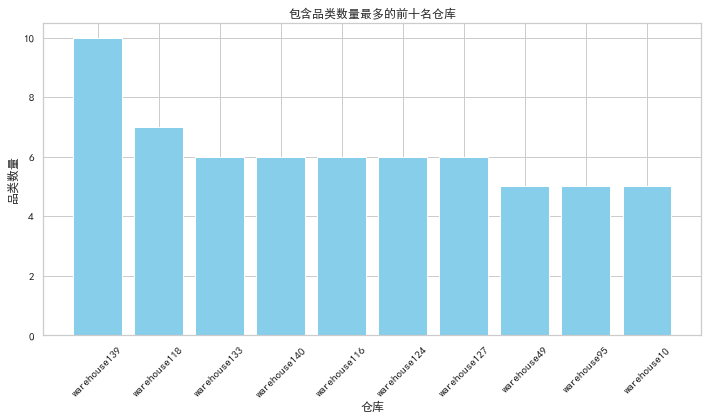

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
# 设置matplotlib绘图时可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 使得坐标轴负号显示正常
# 文件路径
allocation_path = '一品一仓分仓方案_PSO2.csv'
inventory_forecast_path = '所有品类库存量预测结果.csv'
warehouse_info_path = '附件3.csv'

# 读取数据
allocation_df = pd.read_csv(allocation_path)
inventory_forecast_df = pd.read_csv(inventory_forecast_path, encoding='gbk')
warehouse_info_df = pd.read_csv(warehouse_info_path, encoding='gbk')

# 标准化列名，去除多余空格
allocation_df.columns = allocation_df.columns.str.strip()
inventory_forecast_df.columns = inventory_forecast_df.columns.str.strip()
warehouse_info_df.columns = warehouse_info_df.columns.str.strip()



# 数据处理
# 统计每个仓库的品类数量
warehouse_counts = allocation_df['仓库'].value_counts()

# 获取包含品类数量最多的前十名仓库
top_10_warehouses = warehouse_counts.head(10)

# 前十名仓库包含的品类数量柱状图
plt.figure(figsize=(10, 6))
plt.bar(top_10_warehouses.index, top_10_warehouses.values, color='skyblue')
plt.xlabel('仓库')
plt.ylabel('品类数量')
plt.title('包含品类数量最多的前十名仓库')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_warehouses_bar_chart.png')
plt.show()




In [63]:
import pandas as pd

# 文件路径
allocation_path = '一品一仓分仓方案_PSO2.csv'

# 读取分配数据
allocation_df = pd.read_csv(allocation_path)

# 挑选需要展示的品类（按照题目要求展示部分品类）
# 假设我们展示图中看到的品类
selected_categories = [
    'category1', 'category31', 'category61', 'category91',
    'category121', 'category151', 'category181', 'category211',
    'category241', 'category271', 'category301', 'category331'
]

# 筛选出这些品类的分配方案
selected_allocation_df = allocation_df[allocation_df['品类'].isin(selected_categories)]

# 保存为新的表格
selected_allocation_df.to_csv('selected_allocation_plan.csv', index=False)

# 打印结果确认
print(selected_allocation_df)


              品类            仓库
37    category61   warehouse43
68   category151   warehouse23
87   category121   warehouse58
115  category241  warehouse123
170  category271   warehouse99
171   category91   warehouse73
175  category211  warehouse106
204    category1  warehouse130
247  category301  warehouse105
300  category181  warehouse120
304   category31  warehouse123
331  category331   warehouse10
